In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import random
IMG_SIZE=200

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
training_data=[]
def train_data():
  # labeling 
  label_Yes=[1.0,0.0] 
  label_No=[0.0,1.0] 


  #path of images
  drive_path=['/content/drive/MyDrive/brain_tumor_dataset/yes','/content/drive/MyDrive/brain_tumor_dataset/no']


  #Collecting training data
  #Yes
  for img in tqdm(os.listdir(drive_path[0])): 
    path=os.path.join(drive_path[0],img) #joining path of image and Yes folder
    img=cv2.imread(path,cv2.IMREAD_COLOR) #reading the image
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE)) #resizing the image
    training_data.append([np.array(img),np.array(label_Yes)]) #trainig data (image,label)
  
  #NO
  for img in tqdm(os.listdir(drive_path[1])):
    path=os.path.join(drive_path[1],img)
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    training_data.append([np.array(img),np.array(label_No)])
 

train_data()

100%|██████████| 98/98 [00:00<00:00, 126.14it/s]


In [23]:
#shuffling the data
from random import shuffle
shuffle(training_data)
print("lenght of training data:",len(training_data))

lenght of training data: 253


In [24]:
train,test=training_data[:200],training_data[200:]

In [25]:
# definging the independent and dependant variable

#training data
X_train=np.array([i[0] for i in train])
Y_train=np.array([i[1] for i in train])

#testing data
X_test=np.array([i[0] for i in test])
Y_test=np.array([i[1] for i in test])


In [26]:
print("Shape of X_train:",X_train.shape,"\nShape of Y_train:",Y_train.shape)
print("Shape of X_test:",X_test.shape,"\nShape of Y_test:",Y_test.shape)

Shape of X_train: (200, 200, 200, 3) 
Shape of Y_train: (200, 2)
Shape of X_test: (53, 200, 200, 3) 
Shape of Y_test: (53, 2)


## **Convolution neural network model**
creating a base CNN model: The input layer of shape 200*200 following with the zero-padding, Then a 2D convolution network layer and a Batch Normalization layer of momentum 0.99 and epsilon 0.001, following with the relu Activation Layer and Pooling, Finnaly a Flatten layer and a Dense layer of Softmax Activation function.




In [27]:
#cnn model

def cnn_model():
  model=tf.keras.Sequential([tf.keras.layers.InputLayer((IMG_SIZE,IMG_SIZE,3)),
                             
                             tf.keras.layers.ZeroPadding2D(padding=(3,3)),

                             tf.keras.layers.Conv2D(filters=32,kernel_size=7,strides=(1,1)),

                             tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,beta_initializer='zeros', gamma_initializer='ones',moving_mean_initializer='zeros',moving_variance_initializer='ones'),

                             tf.keras.layers.ReLU(),

                             tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

                             tf.keras.layers.Flatten(),

                             tf.keras.layers.Dense(2,activation='softmax'),                             
                             
                             ])
  return model

conv_model=cnn_model() #calling the model
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) #compliing the model

history=conv_model.fit(x=X_train,y=Y_train,validation_data=(X_train,Y_train),epochs=10,batch_size=32) #fitting the CNN model

Epoch 1/10
7/7 [==============================] - 16s 2s/step - loss: 22.3832 - accuracy: 0.6350 - val_loss: 58.6118 - val_accuracy: 0.8000
Epoch 2/10
7/7 [==============================] - 15s 2s/step - loss: 9.3045 - accuracy: 0.7700 - val_loss: 40.6525 - val_accuracy: 0.6450
Epoch 3/10
7/7 [==============================] - 15s 2s/step - loss: 7.5459 - accuracy: 0.7800 - val_loss: 11.2217 - val_accuracy: 0.8750
Epoch 4/10
7/7 [==============================] - 15s 2s/step - loss: 3.4850 - accuracy: 0.8950 - val_loss: 4.9354 - val_accuracy: 0.8850
Epoch 5/10
7/7 [==============================] - 15s 2s/step - loss: 1.8393 - accuracy: 0.9250 - val_loss: 123.2962 - val_accuracy: 0.4150
Epoch 6/10
7/7 [==============================] - 16s 2s/step - loss: 4.1694 - accuracy: 0.8450 - val_loss: 3.2111 - val_accuracy: 0.8950
Epoch 7/10
7/7 [==============================] - 16s 2s/step - loss: 0.9262 - accuracy: 0.9200 - val_loss: 2.2689 - val_accuracy: 0.9350
Epoch 8/10
7/7 [============

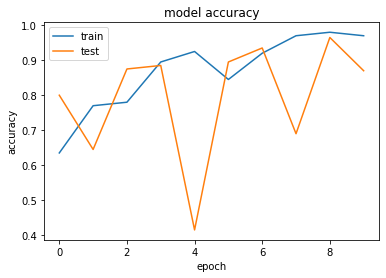

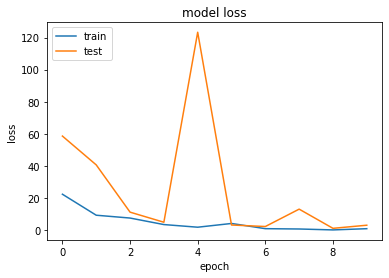

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
conv_model.save('convolution_model.h5') #Saving the CNN model
conv_model.evaluate(X_test,Y_test) #Evaluating the CNN model

2/2 [==============================] - 1s 357ms/step - loss: 23.3356 - accuracy: 0.7170


[23.335596084594727, 0.7169811129570007]

## **DenseNet Model**
Downloading the pretrained weights for the DenseNet121 model, Changing the input shape for the top layer, adding the Global-Average-pooling layer and then adding a Dense layer of Softmax Activation layer.

In [30]:
#DenseNet model

base_model=tf.keras.applications.densenet.DenseNet121(weights=r'imagenet', include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

x=(base_model.output)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

predictions = tf.keras.layers.Dense(2, activation="softmax")(x)

densenet_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
densenet_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy']) #compiling the DenseNet model
history=densenet_model.fit(x=X_train,y=Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=5) #Fitting the DenseNet model


29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/5
7/7 [==============================] - 151s 19s/step - loss: 0.7481 - accuracy: 0.7150 - val_loss: 5.6517 - val_accuracy: 0.5849
Epoch 2/5
7/7 [==============================] - 131s 19s/step - loss: 0.3091 - accuracy: 0.8850 - val_loss: 1.5859 - val_accuracy: 0.6415
Epoch 3/5
7/7 [==============================] - 121s 17s/step - loss: 0.3658 - accuracy: 0.8750 - val_loss: 2.2095 - val_accuracy: 0.4340
Epoch 4/5
7/7 [==============================] - 131s 19s/step - loss: 0.1737 - accuracy: 0.9450 - val_loss: 8.9449 - val_accuracy: 0.4151
Epoch 5/5
7/7 [==============================] - 147s 21s/step - loss: 0.0918 - accuracy: 0.9700 - val_loss: 5.5900 - val_accuracy: 0.5849


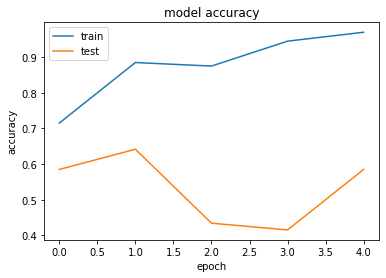

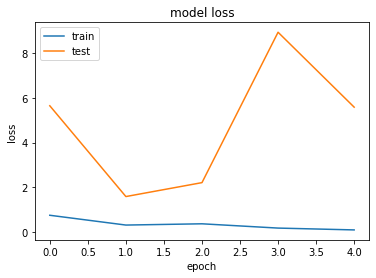

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
densenet_model.save('DenseNet_model.h5') #Saving the DenseNet model
densenet_model.evaluate(X_test,Y_test) #evaluating the DenseNet model


In [34]:
# Defining the process function for processing the imaes while testing 
def process(path):
  img=cv2.imread(path,cv2.IMREAD_COLOR)
  img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  x=img
  img=np.expand_dims(img,axis=0)
  return img,x
def pred_list(pred):
  pred_list=[]
  for i in pred[0]:
    x=format(i,'.8f')
    pred_list.append(x)
  return pred_list

def disease(pred_list):
  x=np.argmax(pred_list)
  if x==0:
    print("Disease: Yes")
  elif x==1:
    print("Disease: No")

    
  

['1.00000000', '0.00000000']
Disease: Yes


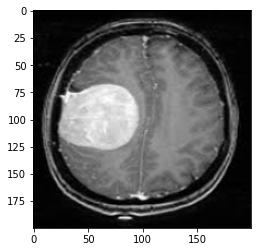

In [39]:
path='/content/drive/MyDrive/brain_tumor_dataset/yes/Y1.jpg'
img,x=process(path)
pred=conv_model.predict(img)
pred=pred_list(pred)
print(pred)
disease(pred)
plt.imshow(x)

['0.00000000', '1.00000000']
Disease: No


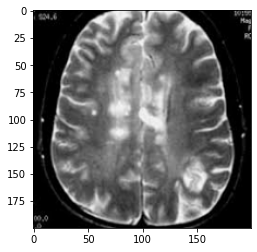

In [40]:
path='/content/drive/MyDrive/brain_tumor_dataset/no/15 no.jpg'
img,x=process(path)
pred=conv_model.predict(img)
pred=pred_list(pred)
print(pred)
disease(pred)
plt.imshow(x)

['1.00000000', '0.00000000']
Disease: Yes


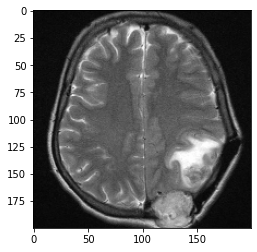

In [41]:
path='/content/drive/MyDrive/brain_tumor_dataset/yes/Y102.jpg'
img,x=process(path)
pred=conv_model.predict(img)
pred=pred_list(pred)
print(pred)
disease(pred)
plt.imshow(x)